# Color quantization & first evaluation of color histogram classifier

## Loading the data

In [10]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import os
from ipywidgets import interact
import ipywidgets as widgets

from dobble_master_race.toolkit import get_data_set

In [11]:
X, Y = get_data_set()
X.shape, Y.shape

((285,), (285,))

# Utils

In [12]:
def evaluate_classifier(clf, X, Y):
    val_dict = cross_validate(clf, X, Y, cv=5, return_estimator=True)
    scores = val_dict["test_score"]
    estimators = val_dict["estimator"]
    
    return scores, estimators, estimators[np.argmax(scores)]

In [27]:
def evaluate_classifiers(clfs, X, Y):
    estimators = []
    scores = []
    best_estimators = []
    
    for clf in clfs:
        val_dict = cross_validate(clf, X, Y, cv=5, return_estimator=True)
        estimators.append(val_dict["estimator"])
        scores.append(val_dict["test_score"])
        best_estimators.append(estimators[-1][np.argmax(scores[-1])])

    return scores, estimators, best_estimators

In [ ]:
def optimize_feature_dim(feature, dim_range, classifiers, classifiers_names, ax=None):
    perfs = [[] for _ in classifiers]
    for sub_feature in feature:
        scores, _, _, = evaluate_classifiers(classifiers, sub_feature, Y)
        for i, cross_score in enumerate(scores):
            perfs[i].append(max(cross_score))
    if ax is not None:
        for name, perf in zip(classifiers_names, perfs):
            ax.plot(dim_range, perf, label=name)
        ax.legend(loc="lower right")
    return [perf.index(max(perf)) + dim_range[0] for perf in perfs]

In [14]:
import pandas as pd
import seaborn as sn

def print_confusion_matrix(predicted: np.array, actual: np.array) -> None:
    plt.figure(figsize=(11, 10))
    confusion_matrix = pd.crosstab(actual, predicted, rownames=['Actual'], colnames=['Predicted'], margins=True)
    plt.tick_params(axis='both', which='major', labelsize=10, labelbottom=True, bottom=True, top=True, labeltop=True)
    sn.heatmap(confusion_matrix, annot=True, vmax=np.max(confusion_matrix.max()[:-1]))
    plt.show()

In [15]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.dummy import DummyClassifier

from sklearn.model_selection import cross_validate
classifiers = [SVC(), KNeighborsClassifier(), RandomForestClassifier(), DummyClassifier(strategy='uniform')]

## What the data looks like ?

In [16]:
nb_class = np.max(Y)

@interact(class_=widgets.BoundedIntText(min=1, max=nb_class))
def print_class(class_: int) -> None:
    _, ax_arr = plt.subplots(nrows=1, ncols=5, figsize=(12,4))
    for i, x in enumerate(X[Y == class_]):
        ax_arr[i].imshow(x)

interactive(children=(BoundedIntText(value=1, description='class_', max=57, min=1), Output()), _dom_classes=('…

## Image mask

In [17]:
gray_threshold = 245

masks = np.array([
    np.array(img.sum(axis=-1) < (gray_threshold * 3),
             dtype=np.uint8)
    for img in X
], dtype=object)

@interact(class_=widgets.BoundedIntText(min=1, max=nb_class))
def print_class(class_: int) -> None:
    _, ax_arr = plt.subplots(nrows=1, ncols=5, figsize=(12,4))
    for i, mask in enumerate(masks[Y == class_]):
        ax_arr[i].imshow(mask, cmap='gray')

interactive(children=(BoundedIntText(value=1, description='class_', max=57, min=1), Output()), _dom_classes=('…

## Compute Hu Moments

In [18]:
moments = np.array([cv.moments(mask, binaryImage=True) for mask in masks])
hu_moments = np.array([cv.HuMoments(mask_moments) for mask_moments in moments])
hu_moments = hu_moments.reshape(285, 7)

@interact(class_=widgets.BoundedIntText(min=1, max=nb_class))
def print_class(class_: int) -> None:
    _, ax_arr = plt.subplots(nrows=1, ncols=5, figsize=(12,4))
    class_moments = hu_moments[Y == class_]
    for i, mask in enumerate(masks[Y == class_]):
        ax_arr[i].imshow(mask, cmap='gray')
        ax_arr[i].axis("off")
        ax_arr[i].set_title("Order 0 moments:\n{}".format(np.round(class_moments[i][0], 2)))

interactive(children=(BoundedIntText(value=1, description='class_', max=57, min=1), Output()), _dom_classes=('…

## Classify classes with Hu Moments

In [19]:
scores, _, best_estimators = evaluate_classifiers(classifiers, hu_moments, Y)

for clf, scs in zip(classifiers, scores):
    print(f"{type(clf).__name__} scores:", scs)

best_svc, best_knn, best_rnd, best_dummy = best_estimators

SVC scores: [0.9122807  0.92982456 0.94736842 0.85964912 0.92982456]
KNeighborsClassifier scores: [0.92982456 0.9122807  0.94736842 0.9122807  0.92982456]
RandomForestClassifier scores: [0.98245614 1.         1.         1.         1.        ]
DummyClassifier scores: [0.01754386 0.03508772 0.01754386 0.         0.01754386]


We can see that classifiers gives us really good results, this is because Hu moments are:
- Invariant to scale
- Invariant to rotation
- Invariant to translation
- Deterministic

[2, 3, 3]


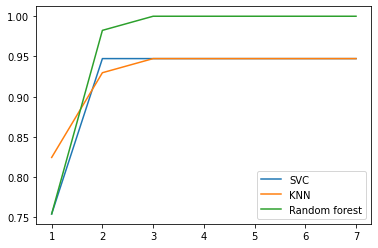

In [31]:
feature = [np.array(hu_moments[:, :i]) for i in range(1, 8)]
best_dims = optimize_feature_dim(feature, range(1, 8), classifiers[:-1], ["SVC", "KNN", "Random forest"], plt)
print(best_dims)

## Compute Aspect Ratios (AR)

Aspect Ratios (AR) are computed by finding the oriented bounding box of the mask and computing this formula:

$$
  Aspect\,ratio = \frac{Largest\,dimension}{Smallest\,dimension}
$$

In [57]:
contours = np.array(
    [cv.findContours(mask, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)[0] for mask in masks],
    dtype=object)
bounding_rects = np.array([cv.minAreaRect(max(contour, key=lambda c: cv.contourArea(c))) for contour in contours], dtype=object)
aspect_ratios = np.array([max(rect[1]) / min(rect[1]) for rect in bounding_rects])

print("Aspect ratios (width / height):")
offset = 15
@interact(class_=widgets.BoundedIntText(min=1, max=nb_class))
def print_class(class_: int) -> None:
    _, ax_arr = plt.subplots(nrows=1, ncols=5, figsize=(12,4))
    class_rects = bounding_rects[Y == class_]
    class_ratios = aspect_ratios[Y == class_].reshape(5)
    for i, mask in enumerate(masks[Y == class_]):
        to_show = cv.copyMakeBorder(mask * 255, offset, offset, offset,
                                    offset, cv.BORDER_CONSTANT, value=0)
        to_show = cv.cvtColor(to_show, cv.COLOR_GRAY2RGB)
        box = [np.int0(cv.boxPoints(class_rects[i]))]
        cv.drawContours(to_show, box, -1, (0, 200, 0), offset=(offset, offset), thickness=3)
        ax_arr[i].imshow(to_show)
        ax_arr[i].axis("off")
        ax_arr[i].set_title("AR = {}".format((round(class_ratios[i], 2))))
        
aspect_ratios = aspect_ratios.reshape(-1, 1);

Aspect ratios (width / height):


interactive(children=(BoundedIntText(value=1, description='class_', max=57, min=1), Output()), _dom_classes=('…

## Classify classes with Aspect Ratios

In [59]:
scores, _, best_estimators = evaluate_classifiers(classifiers, aspect_ratios, Y)

for clf, scs in zip(classifiers, scores):
    print(f"{type(clf).__name__} scores:", scs)

best_svc, best_knn, best_rnd, best_dummy = best_estimators

SVC scores: [0.64912281 0.54385965 0.63157895 0.56140351 0.68421053]
KNeighborsClassifier scores: [0.61403509 0.59649123 0.59649123 0.56140351 0.63157895]
RandomForestClassifier scores: [0.61403509 0.56140351 0.59649123 0.54385965 0.56140351]
DummyClassifier scores: [0.         0.         0.         0.03508772 0.        ]


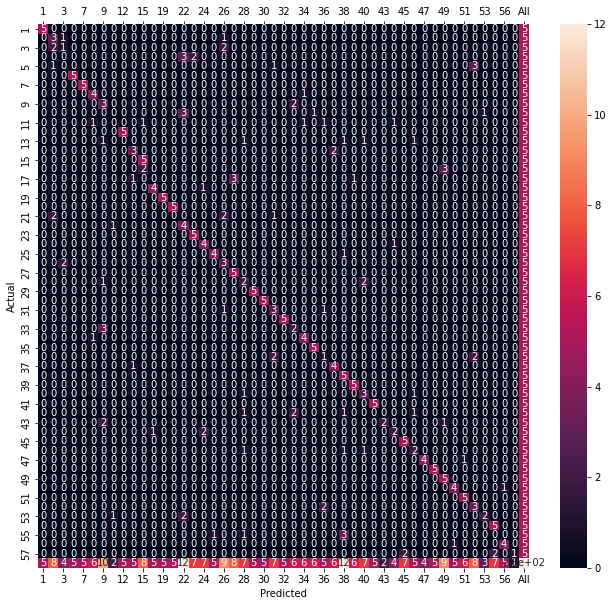

In [60]:
print_confusion_matrix(best_svc.predict(aspect_ratios), Y)

By looking at the confusion matrix we can see that classifiers are really struggling on certain classes.<br>
Let's take a look at classes 3 and 52:<br><br>
> **Class 3:**![notebook_resources/class_3_aspect_ratios.png](notebook_resources/class_3_aspect_ratios.png "class 3")<br>
**Class 52:**![notebook_resources/class_52_aspect_ratios.png](notebook_resources/class_52_aspect_ratios.png "class 52")<br>
We understand that the aspect ratio is not deterministic for images with same proportions.<br> This is therefore a pretty bad descriptor for our problem.